GRAMMATICAL ERROR CORRECTION USING
T5 TRANSFORMER MODEL


Pooja Sasikumar 22BAI1437

In [ ]:
!pip install -q transformers datasets sentencepiece sacrebleu evaluate accelerate rouge_score nltk wordcloud matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.1 MB/s eta 0:00:00


In [ ]:
import torch

Data Collection  

In [ ]:
from google.colab import files
print("Upload your kaggle.json file (from Kaggle Account > Create API Token)")
files.upload()

Upload your kaggle.json file (from Kaggle Account > Create API Token)


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"poojasasikumar","key":"282f536ea08093c9f4f656abb52a81ba"}'}

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d pranav082001/grammaratical-error-correction-dataset
!unzip -o grammaratical-error-correction-dataset.zip -d /content/

Dataset URL: https://www.kaggle.com/datasets/pranav082001/grammaratical-error-correction-dataset
License(s): unknown
  0% 0.00/130k [00:00<?, ?B/s]
100% 130k/130k [00:00<00:00, 402MB/s]
Archive:  grammaratical-error-correction-dataset.zip
  inflating: /content/eval_updated.csv  
  inflating: /content/train_updated.csv  


Data Loading  

In [ ]:
import pandas as pd

train_df = pd.read_csv("/content/train_updated.csv")
test_df  = pd.read_csv("/content/eval_updated.csv")

print("Train samples:", len(train_df))
print("Test samples:", len(test_df))
train_df.head()


Train samples: 3016
Test samples: 2988


,input,target
0,So I think we can not live if old people coul...,So I think we would not be alive if our ancest...
1,So I think we can not live if old people coul...,So I think we could not live if older people d...
2,So I think we can not live if old people coul...,So I think we can not live if old people could...
3,So I think we can not live if old people coul...,So I think we can not live if old people can n...
4,For not use car .,Not for use with a car .


Data Cleaning  

In [ ]:
# Check for duplicate rows
print("Training set duplicates:", train_df.duplicated().sum())
print("Test set duplicates:", test_df.duplicated().sum())

# Remove duplicates
train_df = train_df.drop_duplicates()
test_df = test_df.drop_duplicates()

print("After removing duplicates:")
print("Training set size:", len(train_df))
print("Test set size:", len(test_df))


Training set duplicates: 516
Test set duplicates: 609
After removing duplicates:
Training set size: 2500
Test set size: 2379


In [ ]:
import re

def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = text.strip()                # Remove leading/trailing spaces
    return text

# Apply cleaning
train_df['input'] = train_df['input'].apply(clean_text)
train_df['target'] = train_df['target'].apply(clean_text)
test_df['input'] = test_df['input'].apply(clean_text)
test_df['target'] = test_df['target'].apply(clean_text)

print("Sample after cleaning:")
print(train_df.sample())


Sample after cleaning:
                                                 input  \
403  It 's normal : propose something to the client...   

                                                target  
403  It 's normal : propose something to the client...  


Data Analysis and Visualization

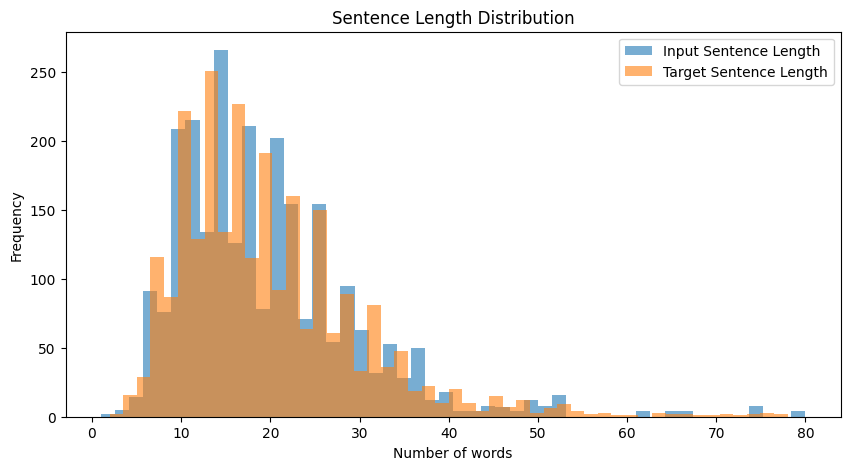

In [ ]:
import matplotlib.pyplot as plt
train_lengths = train_df['input'].apply(lambda x: len(x.split()))
target_lengths = train_df['target'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10,5))
plt.hist(train_lengths, bins=50, alpha=0.6, label='Input Sentence Length')
plt.hist(target_lengths, bins=50, alpha=0.6, label='Target Sentence Length')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.title('Sentence Length Distribution')
plt.legend()
plt.show()

In [ ]:
print("Avg input sentence length:", train_df['input'].apply(lambda x: len(x.split())).mean())
print("Avg target sentence length:", train_df['target'].apply(lambda x: len(x.split())).mean())


Avg input sentence length: 19.7352
Avg target sentence length: 19.9692


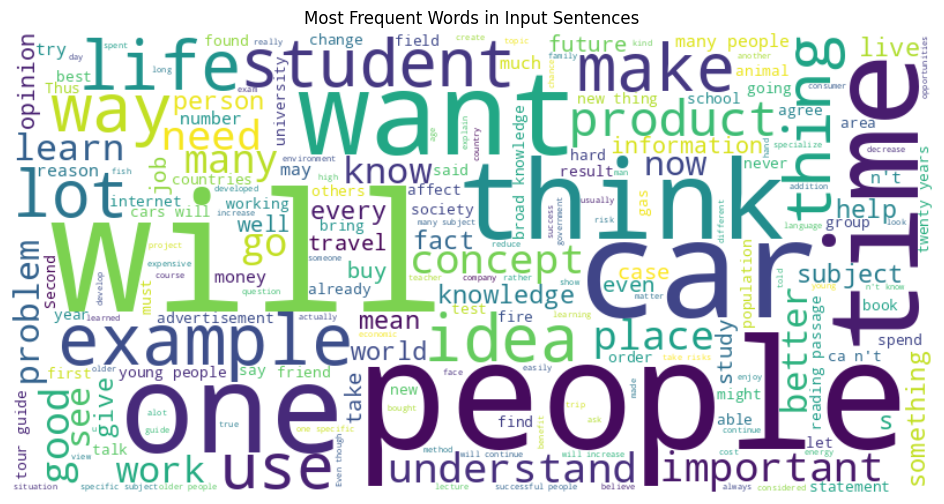

In [ ]:
from wordcloud import WordCloud
all_text = ' '.join(train_df['input'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(15,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Words in Input Sentences")
plt.show()


Dataset Conversion for Model Input

In [ ]:
from datasets import Dataset, DatasetDict

train_data = Dataset.from_pandas(train_df[['input', 'target']])
test_data  = Dataset.from_pandas(test_df[['input', 'target']])

dataset = DatasetDict({
    "train": train_data,
    "test": test_data
})

print(dataset)


DatasetDict({
    train: Dataset({
        features: ['input', 'target', '__index_level_0__'],
        num_rows: 2500
    })
    test: Dataset({
        features: ['input', 'target', '__index_level_0__'],
        num_rows: 2379
    })
})


Loading the T5 Transformer model

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_name = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to("cuda")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Tokenization and Preprocessing

In [ ]:
max_input_length = 128
max_target_length = 128

def preprocess_function(examples):
    inputs = ["fix grammar: " + ex for ex in examples["input"]]
    targets = [ex for ex in examples["target"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True, padding="max_length")
    labels = tokenizer(text_target=targets, max_length=max_target_length, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2379 [00:00<?, ? examples/s]

Model Fine-Tuning

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./t5_small_grammar_model",
    learning_rate=3e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_steps=100,
    fp16=torch.cuda.is_available(),
    report_to="none"
)


In [ ]:
from transformers import AutoModelForSeq2SeqLM, Trainer, DataCollatorForSeq2Seq
import torch

model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to("cuda")
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
)


In [ ]:
trainer.train()


Step,Training Loss
100,1.006200
200,0.153200
300,0.144400
400,0.123400
500,0.120400
600,0.119500
700,0.110400
800,0.096100
900,0.104700
1000,0.103700


TrainOutput(global_step=1565, training_loss=0.1648599487524063, metrics={'train_runtime': 183.6686, 'train_samples_per_second': 68.057, 'train_steps_per_second': 8.521, 'total_flos': 422943129600000.0, 'train_loss': 0.1648599487524063, 'epoch': 5.0})

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
import os

save_dir = "/content/drive/MyDrive/t5_small_grammar_model_final"
os.makedirs(save_dir, exist_ok=True)
print("Saving model to:", save_dir)


Saving model to: /content/drive/MyDrive/t5_small_grammar_model_final


In [ ]:
trainer.save_model(save_dir)         # saves model weights & config
tokenizer.save_pretrained(save_dir)  # saves vocab + tokenizer files


('/content/drive/MyDrive/t5_small_grammar_model_final/tokenizer_config.json',
 '/content/drive/MyDrive/t5_small_grammar_model_final/special_tokens_map.json',
 '/content/drive/MyDrive/t5_small_grammar_model_final/spiece.model',
 '/content/drive/MyDrive/t5_small_grammar_model_final/added_tokens.json',
 '/content/drive/MyDrive/t5_small_grammar_model_final/tokenizer.json')

Test with sample sentences

In [ ]:
from transformers import pipeline

grammar_corrector = pipeline(
    "text2text-generation",
    model="./t5_small_grammar_model_final",
    tokenizer=tokenizer,
    device=0  # use GPU
)

sample_sentences = [
    "She go to school yesterday.",
    "They was playing football.",
    "I is very happy.",
    "The movie are interesting."
]

for s in sample_sentences:
    result = grammar_corrector(s, max_new_tokens=64, num_beams=5)
    print(f"Input : {s}")
    print(f"Output: {result[0]['generated_text']}\n")


Device set to use cuda:0


Input : She go to school yesterday.
Output: She went to school yesterday.

Input : They was playing football.
Output: They were playing football.

Input : I is very happy.
Output: I am very happy.

Input : The movie are interesting.
Output: The movie is interesting.



In [ ]:
print("Enter sentences to correct grammar. Type 'q' to quit.")

while True:
    sentence = input("Input: ")
    if sentence.lower() == 'q':
        break

    corrected = grammar_corrector(sentence, max_new_tokens=64, num_beams=5)
    print("Corrected:", corrected[0]['generated_text'])


Enter sentences to correct grammar. Type 'q' to quit.
Input: I goes to the mall
Corrected: I go to the mall .
Input: She buyed a new car yesturday.
Corrected: She bought a new car yesturday .
Input: This movie are very boreing.
Corrected: This movie is very boring.
Input: q


Confidence Score Calculation

In [ ]:
import torch

sample_sentences = [
    "She go to school yesterday.",
    "He dont like apple.",
    "They was playing football.",
    "I is very happy.",
    "The movie are interesting."
]

# Function to generate correction + confidence
def correction_with_confidence(sentence):
    inputs = tokenizer("fix grammar: " + sentence, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            output_scores=True,
            return_dict_in_generate=True,
            num_beams=5,
            max_new_tokens=64
        )

    # Get corrected text
    corrected_text = tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)

    # Calculate confidence
    if hasattr(outputs, "sequences_scores") and outputs.sequences_scores is not None:
        confidence = torch.exp(outputs.sequences_scores[0]).item()
    else:
        confidence = 0.0

    return corrected_text, confidence


for s in sample_sentences:
    corrected, conf = correction_with_confidence(s)
    print(f"Input: {s}")
    print(f"Corrected: {corrected}")
    print(f"Confidence: {conf:.2f}")
    print("-" * 50)


Input: She go to school yesterday.
Corrected: She went to school yesterday.
Confidence: 0.86
--------------------------------------------------
Input: He dont like apple.
Corrected: He does not like apple.
Confidence: 0.81
--------------------------------------------------
Input: They was playing football.
Corrected: They were playing football.
Confidence: 0.90
--------------------------------------------------
Input: I is very happy.
Corrected: I am very happy.
Confidence: 0.94
--------------------------------------------------
Input: The movie are interesting.
Corrected: The movie is interesting.
Confidence: 0.92
--------------------------------------------------


Evaluation Metrics

In [ ]:
import evaluate
from tqdm import tqdm
from nltk.translate.gleu_score import corpus_gleu

In [ ]:
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

preds = []

for text in tqdm(inputs):

    inputs_tok = tokenizer(
        "fix grammar: " + text,
        return_tensors="pt",
        truncation=True,
        max_length=128
    ).to(device)

    outputs = model.generate(**inputs_tok, max_length=128, num_beams=4)

    pred_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    preds.append(pred_text.strip())


100%|██████████| 2379/2379 [14:02<00:00,  2.82it/s]


In [ ]:
# BLEU
bleu = evaluate.load("sacrebleu")
bleu_score = bleu.compute(predictions=preds, references=[[r] for r in targets])
print(f"BLEU score: {bleu_score['score']:.2f}")

# ROUGE
!pip install rouge_score -q
rouge = evaluate.load("rouge")
rouge_score = rouge.compute(predictions=preds, references=targets)
print("ROUGE scores:")
for k,v in rouge_score.items():
    print(f"{k}: {v:.2f}")

# GLEU
references = [[r.split()] for r in targets]
predictions = [p.split() for p in preds]
gleu_score = corpus_gleu(references, predictions)
print(f"GLEU score: {gleu_score*100:.2f}")


BLEU score: 64.54


ROUGE scores:
rouge1: 0.85
rouge2: 0.70
rougeL: 0.84
rougeLsum: 0.84
GLEU score: 49.27


Training Loss Curve

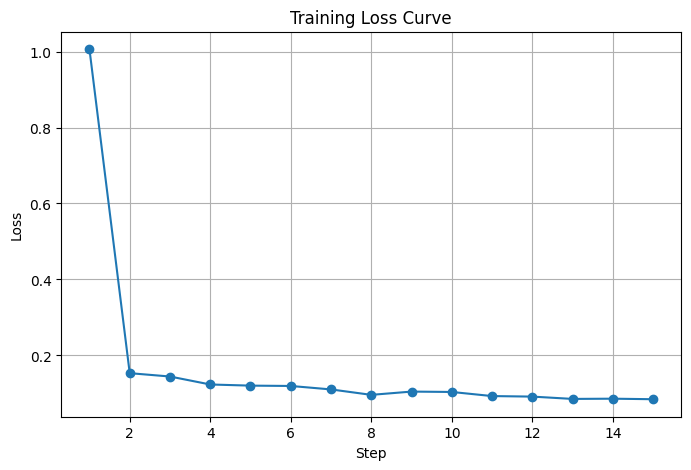

In [ ]:
import matplotlib.pyplot as plt

losses = [log["loss"] for log in trainer.state.log_history if "loss" in log]
steps = list(range(1, len(losses)+1))

plt.figure(figsize=(8,5))
plt.plot(steps, losses, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [ ]:
from transformers import AutoModelForSeq2SeqLM

model_dir = "/content/drive/MyDrive/t5_small_grammar_model_final"
model = AutoModelForSeq2SeqLM.from_pretrained(model_dir)

print(model)
print("Encoder architecture:\n", model.encoder)
print("\nDecoder architecture:\n", model.decoder)


In [ ]:
!pip install gradio --quiet

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import gradio as gr
import torch
import difflib

In [ ]:
model_dir = "/content/drive/MyDrive/t5_small_grammar_model_final"

tokenizer = AutoTokenizer.from_pretrained(model_dir, local_files_only=True)
model = AutoModelForSeq2SeqLM.from_pretrained(model_dir, local_files_only=True)

print(" Model loaded successfully from Drive!")


 Model loaded successfully from Drive!


Gradio interface for grammar correction and highlighting

In [ ]:
def correct_grammar_color(text):
    if not text.strip():
        return "<i>Please enter some text.</i>"

    input_text = "fix grammar: " + text
    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
    # Generate output with confidence
    outputs = model.generate(
        **inputs,
        max_length=512,
        num_beams=5,
        output_scores=True,
        return_dict_in_generate=True
    )
    corrected = tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)
    score = outputs.sequences_scores[0]
    confidence = torch.exp(score).item()
    # Tokenize words
    orig_words = text.split()
    corr_words = corrected.split()
    sm = difflib.SequenceMatcher(a=orig_words, b=corr_words)
    highlighted_orig = ""
    highlighted_corr = ""

    for tag, i1, i2, j1, j2 in sm.get_opcodes():
        if tag == "equal":
            highlighted_orig += " ".join(orig_words[i1:i2]) + " "
            highlighted_corr += " ".join(corr_words[j1:j2]) + " "

        elif tag == "replace":
            highlighted_orig += " ".join([f"<span style='background-color:#ff4b4b;color:white'>{w}</span>" for w in orig_words[i1:i2]]) + " "
            highlighted_corr += " ".join([f"<span style='background-color:#00b300;color:white'>{w}</span>" for w in corr_words[j1:j2]]) + " "

        elif tag == "insert":
            highlighted_corr += " ".join([f"<span style='background-color:#00b300;color:white'>{w}</span>" for w in corr_words[j1:j2]]) + " "

        elif tag == "delete":
            highlighted_orig += " ".join([f"<span style='background-color:#ff4b4b;color:white'>{w}</span>" for w in orig_words[i1:i2]]) + " "

    html_output = f"""
    <div style='font-size:16px; line-height:1.5'>
        <b> Original:</b> {highlighted_orig}<br><br>
        <b>Corrected:</b> {highlighted_corr}<br><br>
        <b>Confidence Score:</b> {confidence:.2f}
    </div>
    """
    return html_output

iface = gr.Interface(
    fn=correct_grammar_color,
    inputs=gr.Textbox(
        lines=4,
        placeholder="Type  a grammatically incorrect sentence here...",
        label="Your Input"
    ),
    outputs=gr.HTML(label="Correction Result"),
    title=" Grammar Correction with T5 Model",
    description="Type a sentence to correct its grammar.",
    theme="gradio/soft",
    allow_flagging="never",
    examples=[
        ["He go to school every day."],
        ["She don't likes coffee."],
        ["I has finish my homework."]
    ]
)

iface.launch(share=True)


/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1655cd4a4c38aa1ee4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
